In [69]:
%matplotlib inline
import numpy as np
from __future__ import division
import matplotlib.pyplot as plt
from scipy.integrate import quad
import astropy.constants as const
import astropy.units as u
import h5py

import random

from numba import double
from numba.decorators import jit, autojit

In [70]:
c = const.c.to(u.km / u.s).value # km/s

# Load in z = 2.45 simulation data

Note: It has already been converted to hdf5 using `simdata_to_HDF5.ipynb`

We want to average over 2000 random sightlines of 50 boxes (files) across. In order to do this I am creating a (50, 2000) array of random indices. 

Can set `step` to speed up code by skipping rows


In [71]:
z = 2.45

### read in data and set global variables

In [72]:
f = h5py.File('../../../Data/z245.hdf5', 'r')

# speed up code by making bigger steps through data
step = 100

# make a velocity array with the correspoding length and delta v
dv = (f['z2.45'][1, 1, 0] - f['z2.45'][1, 0, 0])*step

tau_HILya_data = np.asarray(f['z2.45'][:, ::step, :], dtype=np.float64)
n_HI_data = np.asarray(f['z2.45'][:, ::step, :], dtype=np.float64)

In [73]:
print dv

84.41


In [74]:
tau_HILya_data.shape

(2000, 30, 10)

In [75]:
num_files = tau_HILya_data.shape[0]
num_rows = tau_HILya_data.shape[1]
num_cells = 90
num_lines = 2 # number of Lyman transitions per Haiman et al 2000(?)
wav_min = 600.0

In [76]:
# make random indices array
# range from 0, 2000, in a 50 x 2000 shape
idx = np.random.randint(num_files, size=(num_cells, num_files))

### `tau_HILya` is now a 2000x150000 array (2000 sightlines by 50*num_files)

### each sightline is a composed of 50 random files stacked together (flattened).

In [77]:
tau_HILya = tau_HILya_data[idx,:,1].reshape(num_files,num_cells*num_rows)

In [78]:
def make_stacks(data, num_files, num_cells, num_rows):
    idx = np.random.randint(num_files, size=(num_cells, num_files))
    return data[idx,:,1].reshape(num_files,num_cells*num_rows)

### Useful functions to compute where in an array are the values equal

In [79]:
def find_nearest(array,value):
    idx = (np.fabs(array-value)).argmin()
    return idx

@jit
def vec_find_nearest(array, values):
    idxarr = np.empty_like(values, dtype=np.int32)
    for i in xrange(len(values)):
        idxarr[i] = (np.fabs(array-values[i])).argmin()
    return idxarr

# Lyman continuum

In [80]:
# compute the wavlengths of the transitions
def lyman_lambda(nmax):
    R_h = const.Ryd.to(1 / u.Angstrom).value # Rydberg constant in 1 /angstroms
    return (R_h*(1 - (1/nmax**2)))**-1

lyman_wav = np.vectorize(lyman_lambda)

# compute the oscillator strengths
def gf_1n(nn):
    """ A function to calculate the oscillator strengths of of the Lyman series (n'=1).
        
        Reference: RL equation 10.46 (p.281)
    """
    if nn > 1.9:
        gf = (2**9 * nn**5 * (nn-1)**(2*nn-4)) / (3*(nn+1)**(2*nn+4))
        return gf
    else:
        print "must input integer >= 2"

gf_1n = np.vectorize(gf_1n)

## Calclutate Column density:

From Rybicki & Lightman eq 10.70, using the line-center cross section for each atom, neglecting stimulated emission:

$$ \tau = N \sigma$$

$$ \sigma_{\nu_{0}} = \frac{\pi e^2}{mc} f_{12} \frac{1}{\Delta \nu_{D} \sqrt{\pi}} $$ 

and integrating over $\nu$ gives:

$$ \sigma_{\nu_{0}} = \frac{\pi e^2}{mc} f_{12} $$

then: 

$$ N_{HI} = \frac{\Delta v_i \tau_{Ly\alpha} mc}{f_{12} \pi e^2} $$

We need this to compute the Lyman continuum optical depth since there is no spacial information in the data, only velocity. 

Note: $f_{12} = \frac{gf_{12}}{2}$ where $g = 2$ is the degeneracy of the electron.

In [81]:
@jit
def make_column_density(t_HILya):
    m_h = const.m_p.cgs.value
    e = const.e.gauss.value
    m_e = const.m_e.cgs.value
    c_cmsec = const.c.cgs.value
    c_kmsec = const.c.to(u.km / u.s).value
    lyalpha = lyman_lambda(2)
    nuLya = c_cmsec/(lyalpha*1e-8)  #make this prettier!
    dnu = nuLya*dv/c_kmsec
    
    constants = (dnu*m_e*c_cmsec/(np.pi*e**2 * gf_1n(2)/2))
    # constants = (dnu*m_e*c_cmsec/(np.pi*e**2 * gf_1n(2)/2))
    # 1.6e17 should equal give tau 1
    
    # print "for testing: ", m_e, e, nuLya, dnu, c_cmsec, c_kmsec,  constants 
    nfiles = t_HILya.shape[0]
    nwaves = t_HILya.shape[1]
    
    # print(lyman_lambda(2), gf_1n(2)/2,constants)
    
    N_HI = np.empty_like(t_HILya, dtype=np.float64)
    for i in xrange(nfiles):
        for j in xrange(nwaves):
            N_HI[i,j] = t_HILya[i,j]*constants
    return N_HI

In [82]:
N_HI = make_column_density(tau_HILya)

### Compute the wavlength as its redshifted across the sightline

$$ \lambda \approx \big(1 + \frac{dv}{c}\big)^{N} $$

$$ \lambda \approx N\big(1 + \frac{dv}{c}\big) $$

In [83]:
# create emitted wavelength array
wav_em = np.zeros_like(tau_HILya[1])
wav_em[0] = wav_min
for i in xrange(1, tau_HILya.shape[1]):
    wav_em[i] = wav_em[i-1]*(1 + dv/c)

In [84]:
@jit
def fast_wave_sum(wave_arr, col_dens):
    """ 
    A function to pre-compute the sum over wavelengths used in tau_bf.
    
    input: wavelength array
    
    returns: summed slices of wavelength array
    
    NOTE: uses Numba (@jit) to speed up over 100x
    
    """
    lymanlimit = 911.267050642
    imax = find_nearest(wave_arr, lymanlimit)
    # tmp = np.ones_like(wave_arr)
    tmp = np.zeros_like(wave_arr)
    sigma0 = 6.30e-18
    ll = lymanlimit*lymanlimit*lymanlimit
    for n in xrange(col_dens.shape[0]):
        for i in xrange(len(wave_arr)):
            # ~4 times faster to multipy instead of power.
            # @jit makes this 4 times faster still. 
            tmp[i] = sigma0*np.sum(wave_arr[i:imax]*wave_arr[i:imax]*wave_arr[i:imax]*col_dens[n,i:imax])/ll
    return tmp
    """    for i in xrange(len(wave_arr)):
        for j in xrange(i,imax):
        # ~4 times faster to multipy instead of power.
        # @jit makes this 4 times faster still. 
            tmp[j] += wave_arr[j]*wave_arr[j]*wave_arr[j]
        tmp[i] *= sigma0/ll
    return tmp"""
@jit
def tau_bf(wave_arr, col_dens):
    """ 
    A function to compute the bound free opacity below the lyman limit.
    
    input: wavelength array, N_HI array (expected to be a nfiles x nrows)
    
    return: nfiles x nrows array of the bf optial depth
    
    NOTE: uses Numba (@jit) to speed it up over 100x
    """
    # col_dens = np.ones_like(col_dens)*1e14 # diagnostic
    # w = fast_wave_sum(wave_arr)
    lymanlimit = 911.267050642
    imax = find_nearest(wave_arr, lymanlimit)
    ll3 = lymanlimit*lymanlimit*lymanlimit
    num_file = col_dens.shape[0]
    num_row = col_dens.shape[1]
    sigma0 = 6.30e-18
    t_bf = np.empty((num_file, num_row), dtype=np.float64)
    for j in xrange(num_file):
        for i in range(num_row):
            t_bf[j,i] = sigma0*np.sum(wave_arr[i:imax]*wave_arr[i:imax]*wave_arr[i:imax]*col_dens[j,i:imax])/ll3
    return t_bf

In [85]:
t_bf = tau_bf(wav_em, N_HI)

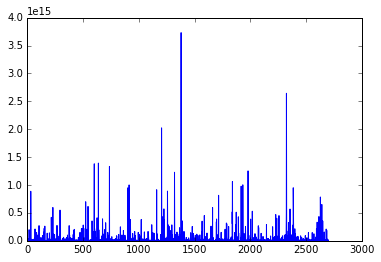

In [86]:
plt.plot(N_HI[100,:])
plt.show()

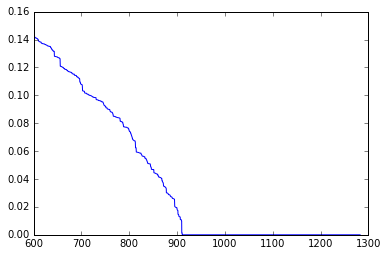

In [87]:
plt.plot(wav_em, t_bf[6,:])

## Add the Lyman-n Forest

$ \tau_{n} = \frac{gf_{1n}}{gf_{Ly\alpha}} \tau_{Ly\alpha} = f_n\tau_{Ly\alpha}$

This function computes the lyman transitions wavelength, finds the corresponding index and adds the opacity due to that line to the total opacity. 

In [88]:
@jit
def tau_HILyn(wave_em, t_HILya, nlines, debug=False, mean=False):
    """ This function computes the Lyman-n forest opacity.
    
        input: emitted wavelength array, Lyman alpha opacity array, number of transitions
        
        returns: array of opacity in the same shape as tau_HILya
    """
    # array of oscillator strengths
    # go backwards since f_n,lambda_n start at lyman alpha
    f_n = (gf_1n(np.arange(2,nlines+3))/gf_1n(2))[::-1]
    
    # array of transition wavelengths
    lambda_n = lyman_lambda(np.arange(2,nlines+2))[::-1]
    
    nfiles = t_HILya.shape[0]
    
    lymanlimit = 911.267050642
    imax = find_nearest(wave_em, lymanlimit)

    # make an empty array to add in the Lyman alpha opacity
    tau_n = np.zeros_like(t_HILya)
    
    # where does wave_em == lyman-n line
    iarr = vec_find_nearest(wave_em,lambda_n)
    
    # good for debugging:
    # print(f_n,iarr, t_HILya[0,iarr[0]]*f_n[0], wave_em[iarr])
    
    for n in xrange(nfiles):
        # do it for each sightline
        for i in range(nlines):
            
            if debug == False and mean == False:
                # stack the opacity onto the opacity array at the index
                # where wavelength == nth lyman line
                tau_n[n,:iarr[i]] += t_HILya[n,:iarr[i]]*f_n[i]
                # print avg
            elif mean == True:
                tau_n[n,:iarr[i]] += np.mean(t_HILya[n,:iarr[i]])*f_n[i]
                # from old code: tau_n[n:] +=  tau_flat[:len(tau_n[n:])]*f_1n[i]
                
            else:
                # good for debugging:
                tau_n[n,:iarr[i]] += f_n[i]   
                
            # tau_n[n,:iarr[i]] += t_HILya[n,:iarr[i]]*f_n[i]
            
    return tau_n

In [89]:
t_Ly_mean = tau_HILyn(wav_em, tau_HILya, num_lines, mean=True)
t_Ly_homogeneous = tau_HILyn(wav_em, tau_HILya, num_lines, debug=True, mean=False)
t_Ly = tau_HILyn(wav_em, tau_HILya, num_lines)

What does a random sightlines Lyman-n opacity looks like:

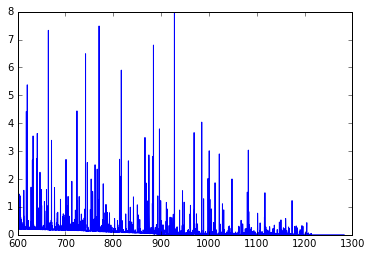

In [90]:
plt.plot(wav_em, t_bf[1,:] + t_Ly[1,:], label=i)
plt.show()

What does a random sightlines combined (Lyman-n & continuum) opacity looks like:

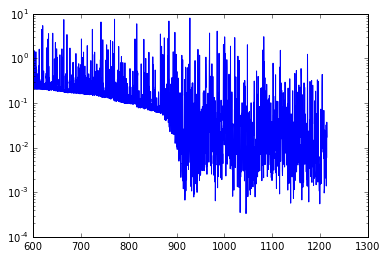

In [91]:
plt.semilogy(wav_em, t_bf[1,:] + t_Ly[1,:])
plt.show()

Compute the average flux over the 2000 sightlines

$$ f = \langle e^{-\tau_{bf+bb}} \rangle $$

### Plot the average spectrum and overlay an individual sightline for comparison. 

In [92]:
tau_tot = t_Ly + t_bf
tau_tot_mean = t_Ly_mean + t_bf
tau_tot_homo = t_Ly_homogeneous + t_bf
tau_tot_slice = t_Ly[399,:] + t_bf[399,:]
# np.mean more accurate with float 64
flux = np.mean(np.exp(-tau_tot*100), axis=0, dtype=np.float64)
flux_mean = np.mean(np.exp(-tau_tot_mean*100), axis=0, dtype=np.float64)
flux_homo = np.mean(np.exp(-tau_tot_homo*100), axis=0, dtype=np.float64)
flux_slice = np.exp(-tau_tot_slice*100)

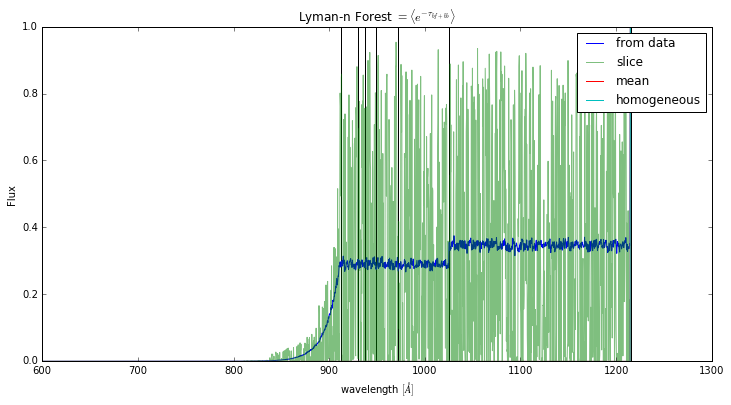

In [93]:
plt.figure(figsize=(12,6))
plt.plot(wav_em, flux, label="from data")
plt.plot(wav_em, flux_slice, alpha=0.5, label="slice")
plt.plot(wav_em, flux_mean, label="mean")
plt.plot(wav_em, flux_homo, label="homogeneous")
ref_lines = lyman_lambda(np.arange(2,8))
plt.vlines(ref_lines, 0, 1)
plt.vlines(912,0,1)
plt.xlabel(r"wavelength $[\AA]$")
plt.ylabel(r"Flux")
plt.title(r"Lyman-n Forest $= \langle e^{-\tau_{bf+bb}} \rangle$")
plt.legend()
plt.show()

# ToDo: 
 - add a mode to include redshift evolution. ie.: after so many boxes shift to a lower redshift
 
 - artificially put down column densities from a simplified $N_{HI}$ distribution drawn from a poisson distribution a guassian profile of width 30 km/s
 


Matt:

number of clusters per bin (N_HI = 10^12.5 to 10^17) = $f L \Delta N_{HI}$

make the clouds gaussian with a width of 20km/s

# Column Density Distribution

In [94]:
@jit
def opticalDepthProfile(dvv, NHI):
    #sigma = 30 # km/s
    #constants = np.sqrt(2*np.pi*sigma*sigma)
    #gaussian = np.exp(-v*v/(2*sigma*sigma)) / constants
    
    """use a guassian for now. Formula provided by Anson, but check with R.L."""
    # constants
    c = const.c.cgs.value
    e = const.e.gauss.value
    m_h = const.m_p.cgs.value
    c_km_s = const.c.to(u.km / u.s).value
    
    # velocity dispersion
    T = 1e4 # Kelvin
    k = const.k_B.cgs.value
    m_p = const.m_p.cgs.value
    sigma_v_squared = 2*k*T/m_p*1e-10 # (km/s)^2
    # should be this
    # simga_v_squared = 30**2
    
    # print np.sqrt(sigma_v_squared)*u.km / u.s
    
    
    # cross section at line center why is this wrong???
    # sigma_Lya = 1 / (np.pi*e**2 * gf_1n(2) / m_h*c)
    sigma_Lya = 4.45e-18
    
    # print sigma_Lya
    
    # opacity profile
    tau_v = c_km_s*sigma_Lya*NHI*np.exp(-dvv**2/sigma_v_squared) / np.sqrt(sigma_v_squared * np.pi)
    
    return tau_v

In [95]:
# opticalDepthProfile(testSkewer,1e14)

In [96]:
testSkewer = np.arange(-100,100)

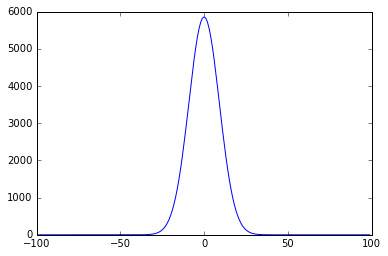

In [187]:
plt.plot(testSkewer, opticalDepthProfile(testSkewer,1e17))

# Cosmology

In [182]:
@jit
def H(zz):
    """ returns Hubble parameter as a function of z in units of km/s/Mpc
    """
    omega_m = 0.3
    H0 = 70*u.km / u.s / u.Mpc
    return H0*np.sqrt(omega_m*(1 + zz)**3)
    

In [183]:
H(z)

<Quantity 245.68990363871285 km / (Mpc s)>

In [184]:
@jit
def CDDF(NHI,beta,zz):
    
    #dN_dxdNHI = 1/(300*u.Mpc)*((1e17*u.cm**-2)**(1.5)) * (NHI*u.cm**-2)**(-1.5)
    dN_dxdNHI = -(1+beta)/(300*u.Mpc)*((1e17*u.cm**-2)**(-(1 + beta))) * (NHI*u.cm**-2)**(beta)
    dN_dvdNHI = dN_dxdNHI * (1+zz) / H(zz) 
    
    return dN_dvdNHI

As a check, we should get 2.34e-5 systems with $N_{HI} = 1 \times 10^{17}$ cm$^{2}$per km/s so $2$ per $100000$ km/s

In [190]:
CDDF(1e17,-1.5,2.45)*1e17

<Quantity 2.3403485103951925e-05 cm2 s / km>

and 300 Mpc = $7 \times 10^{17}$ 

In [192]:
300*u.Mpc*H(2.45) 

<Quantity 73706.97109161386 km / s>

In [193]:
def makeSyntheticSkewer(beta, z):
    width = 30 # km/s
    #This is just a sketch of how you might want to code the contruction
    #of random spectra (not meant to be working code). You will have to define
    #the constants and functions that are relevant for your calculation. 
    #I extracted this fragment from some of Matt McQuinn's code

    #Set the span of the line profiles of your absorbers.  Here dv
    #is the resolution element of your mock spectrum.   
    imax = int(300/width)

    logNMAX = 17.0
    logNMIN = 12.5

    skewer = np.zeros_like(wav_em)
    
    # skewer_size = wav_em.size
    # skewer = np.zeros(3000)
    skewer_size = np.size(skewer) 
    skewer_length = skewer_size*dv # km/s


    #You will first want to set the number of logarithmic bins in NHI
    numN = 20
    dlogN = (logNMAX-logNMIN)/numN

    #Loop over the NHI bins
    for ii in xrange(numN):

        NHI = 10**(dlogN*ii + logNMIN)

        #Draw from a Poisson distribution the number of absorbers along the sightline with NHI in this bin.  
        #Note that if you want to do this in velocity space, you will want the CDDF to be expressed as the 
        #number of absorbers per km/s per logNHI, and you will want "skewer_length" to be in km/s 
        num_absorbers = np.random.poisson(skewer_length*CDDF(NHI,-1.5,z).value*dlogN*NHI)

        # print skewer_size*CDDF(NHI,z)*dlogN, num_absorbers, imax

        #Now lay down the absorbers at a random location along your sightline
        #Loop over absorbers in this NHI bin
        for j in xrange(num_absorbers):

            #The random location of the absorber
            random_point = np.random.randint(0,skewer_size+1)
            # random_point = randomPointArray[j]

            #Add the opacity of this absorber to your sightline
            #The extent of the line profile is set by imax
            for i in xrange(-imax, imax, 1):

                #This mod (%) enforces periodic boundaries
                #Here the opticalDepthProfile should be your line profile (e.g. Gaussian)
                skewer[(random_point+i + skewer_size)%skewer_size] += opticalDepthProfile(i*width, NHI)

    return skewer

In [194]:
synth_skewer = makeSyntheticSkewer(-1.5, z)

In [195]:
%timeit makeSyntheticSkewer(-1.5, z)

1 loops, best of 3: 8.9 s per loop


(0, 40)

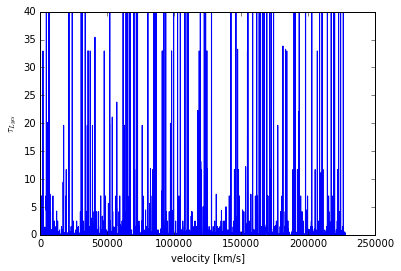

In [161]:
skewer_size = np.size(synth_skewer)
#plt.plot(np.arange(skewer_size)*dv, np.exp(-synth_skewer))
plt.plot(np.arange(skewer_size)*dv, synth_skewer)
plt.xlabel("velocity [km/s]")
plt.ylabel(r"$\tau_{Ly\alpha}$")
plt.ylim(0,40)
# plt.xlim(0,3000)

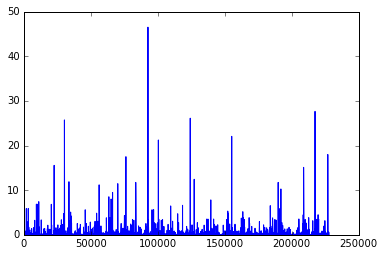

In [162]:
plt.plot(np.arange(np.size(tau_HILya[0]))*dv, tau_HILya[0])

In [163]:
synth_skewer12 = makeSyntheticSkewer(-1.2, z)
synth_skewer15 = makeSyntheticSkewer(-1.5, z)
synth_skewer18 = makeSyntheticSkewer(-1.8, z)
synth_skewer20 = makeSyntheticSkewer(-2.0, z)

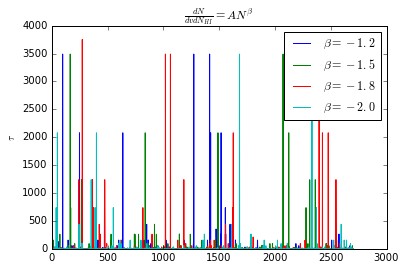

In [164]:
skewer_list = [synth_skewer12, synth_skewer15, synth_skewer18, synth_skewer20]
name_list =  [r"$\beta = -1.2$", r"$\beta = -1.5$", r"$\beta = -1.8$", r"$\beta = -2.0$"]
for s,n in zip(skewer_list,name_list):
    plt.plot(s, label=n)
plt.legend()
plt.title(r"$\frac{dN}{dv dN_{HI}} = A N^\beta$")
plt.ylabel(r"$\tau$")
plt.show()

In [165]:
alist = [synth_skewer12, synth_skewer15, synth_skewer18, synth_skewer20]
skewer_array = np.array(alist)

In [166]:
tau_Lya_synth = tau_HILyn(wav_em, skewer_array, num_lines)

In [167]:
N_HI_synth = make_column_density(skewer_array)

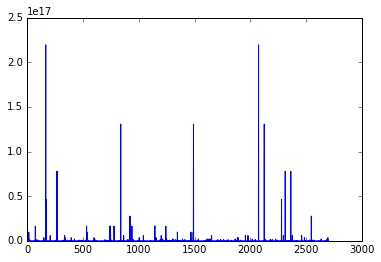

In [173]:
plt.plot(N_HI_synth[1])

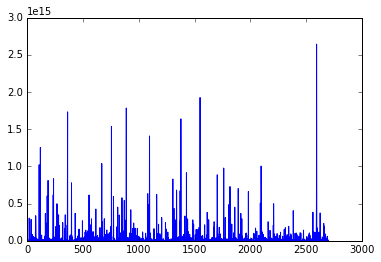

In [175]:
plt.plot(N_HI[1])

In [168]:
t_bf_synth = tau_bf(wav_em, N_HI_synth)

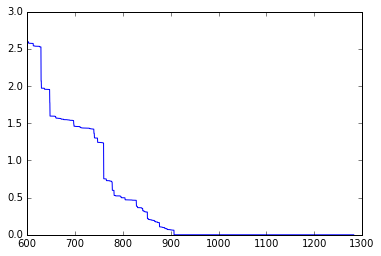

In [178]:
plt.plot(wav_em, t_bf_synth[1])

In [169]:
tau_tot_synth = tau_Lya_synth + t_bf_synth
tau_tot_slice = t_Ly[399,:] + t_bf[399,:]

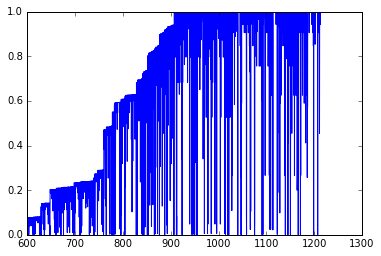

In [171]:
plt.figure()
plt.plot(wav_em, np.exp(-tau_tot_synth[1]))
plt.show()

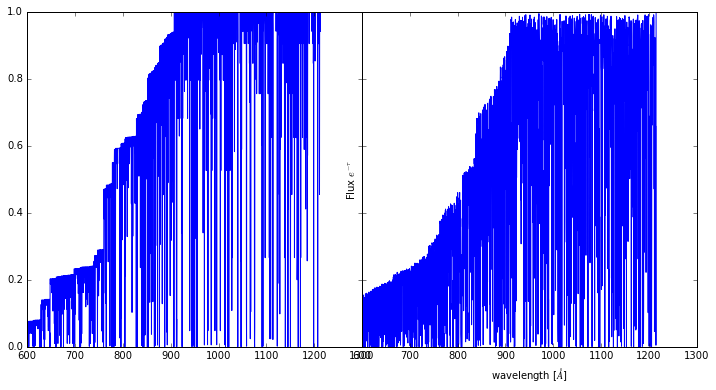

In [181]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, squeeze=True,figsize=(12,6))
plt.xlabel(r"wavelength [$\AA$]")
plt.ylabel(r"Flux $e^{-\tau}$")
ax[0].plot(wav_em, np.exp(-tau_tot_synth[1]))
ax[1].plot(wav_em, np.exp(-tau_tot_slice*10))
fig.subplots_adjust(wspace=0)
# plt.savefig("synth_v_sim.png")

In [157]:
tau_tot_synth.size

10800

(850, 950)

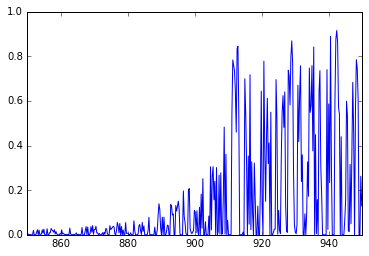

In [158]:
plt.plot(wav_em, np.exp(-tau_tot_slice*110))
plt.xlim(850,950)